In [ ]:
pip install pandas matplotlib scipy seaborn

In [ ]:
import pandas as pd



In [4]:

sentiment = pd.read_csv("/content/drive/MyDrive/internship assignments/fear_greed_index.csv")

sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s')

sentiment.rename(columns={'timestamp': 'datetime'}, inplace=True)


sentiment['date'] = sentiment['datetime'].dt.date


sentiment_clean = sentiment[['date', 'value', 'classification']]

print(sentiment_clean.head())


         date  value classification
0  2018-02-01     30           Fear
1  2018-02-02     15   Extreme Fear
2  2018-02-03     40           Fear
3  2018-02-04     24   Extreme Fear
4  2018-02-05     11   Extreme Fear


In [6]:
trades = pd.read_csv("/content/drive/MyDrive/internship assignments/historical_data.csv")
trades['timestamp'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M")
trades['date'] = trades['timestamp'].dt.date

trades['Closed PnL'] = pd.to_numeric(trades['Closed PnL'], errors='coerce')
trades['Closed PnL'] = trades['Closed PnL'].fillna(0)

daily_pnl = trades.groupby(['Account', 'date'])['Closed PnL'].sum().reset_index()
print(daily_pnl.head())

                                      Account        date  Closed PnL
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11         0.0
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17         0.0
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18         0.0
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22    -21227.0
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26      1603.1


In [7]:
# Add is_win column (1 = profitable day, 0 = loss day)
daily_pnl['is_win'] = (daily_pnl['Closed PnL'] > 0).astype(int)

# Group by account and calculate:
# total days, win days, and win rate
daily_winrate = daily_pnl.groupby('Account').agg(
    total_days=('date', 'nunique'),
    win_days=('is_win', 'sum')
).reset_index()

daily_winrate['daily_win_rate'] = daily_winrate['win_days'] / daily_winrate['total_days']

print(daily_winrate.head())


                                      Account  total_days  win_days  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          24        16   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          52        29   
2  0x271b280974205ca63b716753467d5a371de622ab          12         8   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4         162       144   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd          69        54   

   daily_win_rate  
0        0.666667  
1        0.557692  
2        0.666667  
3        0.888889  
4        0.782609  


In [8]:
daily_stats = daily_pnl.groupby('Account').agg(
    avg_daily_pnl=('Closed PnL', 'mean'),
    std_daily_pnl=('Closed PnL', 'std'),
    min_daily_pnl=('Closed PnL', 'min'),
    max_daily_pnl=('Closed PnL', 'max')
).reset_index()

print(daily_stats.head())


                                      Account  avg_daily_pnl  std_daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012   66676.242499  150401.797346   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd     920.871548    3603.042291   
2  0x271b280974205ca63b716753467d5a371de622ab   -5869.682610   33420.410014   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4     817.684040    2993.284702   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd    2444.318913    4867.743469   

   min_daily_pnl  max_daily_pnl  
0 -175611.000056  533974.662903  
1  -12346.990829   11715.943230  
2 -108176.918700   16706.884912  
3  -19833.530157   14685.787664  
4   -3323.090682   21980.472490  


In [9]:
daily_metrics = daily_winrate.merge(daily_stats, on='Account', how='left')
print(daily_metrics.head())


                                      Account  total_days  win_days  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          24        16   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          52        29   
2  0x271b280974205ca63b716753467d5a371de622ab          12         8   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4         162       144   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd          69        54   

   daily_win_rate  avg_daily_pnl  std_daily_pnl  min_daily_pnl  max_daily_pnl  
0        0.666667   66676.242499  150401.797346 -175611.000056  533974.662903  
1        0.557692     920.871548    3603.042291  -12346.990829   11715.943230  
2        0.666667   -5869.682610   33420.410014 -108176.918700   16706.884912  
3        0.888889     817.684040    2993.284702  -19833.530157   14685.787664  
4        0.782609    2444.318913    4867.743469   -3323.090682   21980.472490  


In [10]:
daily_pnl_sorted = daily_pnl.sort_values(by=['Account', 'date'])

# Cumulative sum → equity curve
daily_pnl_sorted['equity'] = daily_pnl_sorted.groupby('Account')['Closed PnL'].cumsum()

print(daily_pnl_sorted.head())


                                      Account        date  Closed PnL  is_win  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11         0.0       0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17         0.0       0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18         0.0       0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22    -21227.0       0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26      1603.1       1   

    equity  
0      0.0  
1      0.0  
2      0.0  
3 -21227.0  
4 -19623.9  


In [11]:
daily_pnl_sorted = daily_pnl.sort_values(by=['Account', 'date'])

daily_pnl_sorted['equity'] = daily_pnl_sorted.groupby('Account')['Closed PnL'].cumsum()

print(daily_pnl_sorted.head())


                                      Account        date  Closed PnL  is_win  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11         0.0       0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17         0.0       0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18         0.0       0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22    -21227.0       0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26      1603.1       1   

    equity  
0      0.0  
1      0.0  
2      0.0  
3 -21227.0  
4 -19623.9  


In [12]:
def max_drawdown(equity_curve):
    cumulative_max = equity_curve.cummax()
    drawdown = (equity_curve - cumulative_max)
    return drawdown.min()

mdd = daily_pnl_sorted.groupby('Account').apply(
    lambda x: max_drawdown(x['equity'])
).reset_index(name='max_drawdown')

print(mdd)


                                       Account  max_drawdown
0   0x083384f897ee0f19899168e3b1bec365f52a9012 -3.275059e+05
1   0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd -2.250551e+04
2   0x271b280974205ca63b716753467d5a371de622ab -1.272143e+05
3   0x28736f43f1e871e6aa8b1148d38d4994275d72c4 -2.076548e+04
4   0x2c229d22b100a7beb69122eed721cee9b24011dd -3.323091e+03
5   0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -7.237892e+04
6   0x39cef799f8b69da1995852eea189df24eb5cae3c -7.813966e+04
7   0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6 -7.275958e-12
8   0x420ab45e0bd8863569a5efbb9c05d91f40624641  0.000000e+00
9   0x430f09841d65beb3f27765503d0f850b8bce7713  0.000000e+00
10  0x47add9a56df66b524d5e2c1993a43cde53b6ed85 -1.901567e+04
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4 -2.427874e+03
12  0x4f93fead39b70a1824f981a54d4e55b278e9f760 -1.133837e+05
13  0x513b8629fe877bb581bf244e326a047b249c4ff1 -7.112182e+04
14  0x6d6a4b953f202f8df5bed40692e7fd865318264a -8.917810e+01
15  0x72743ae2822edd658c

/tmp/ipython-input-2071854309.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mdd = daily_pnl_sorted.groupby('Account').apply(


In [13]:
sharpe = daily_pnl.groupby('Account').agg(
    sharpe_ratio=('Closed PnL', lambda x: x.mean() / x.std() if x.std() != 0 else None)
).reset_index()

print(sharpe)


                                       Account  sharpe_ratio
0   0x083384f897ee0f19899168e3b1bec365f52a9012      0.443321
1   0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd      0.255582
2   0x271b280974205ca63b716753467d5a371de622ab     -0.175632
3   0x28736f43f1e871e6aa8b1148d38d4994275d72c4      0.273173
4   0x2c229d22b100a7beb69122eed721cee9b24011dd      0.502146
5   0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891     -0.071775
6   0x39cef799f8b69da1995852eea189df24eb5cae3c      0.021546
7   0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6      0.330867
8   0x420ab45e0bd8863569a5efbb9c05d91f40624641      0.479641
9   0x430f09841d65beb3f27765503d0f850b8bce7713      0.454590
10  0x47add9a56df66b524d5e2c1993a43cde53b6ed85      0.288887
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4      0.461063
12  0x4f93fead39b70a1824f981a54d4e55b278e9f760      0.129544
13  0x513b8629fe877bb581bf244e326a047b249c4ff1      0.510989
14  0x6d6a4b953f202f8df5bed40692e7fd865318264a      0.309694
15  0x72743ae2822edd658c

In [14]:
trade_stats = trades.groupby('Account').agg(
    total_trades=('Closed PnL', 'count'),
    wins=('Closed PnL', lambda x: (x > 0).sum()),
    losses=('Closed PnL', lambda x: (x < 0).sum()),
    avg_win=('Closed PnL', lambda x: x[x > 0].mean()),
    avg_loss=('Closed PnL', lambda x: x[x < 0].mean())
).reset_index()

trade_stats['win_rate'] = trade_stats['wins'] / trade_stats['total_trades']

# Expectancy = (win_rate * avg_win) + ((1 - win_rate) * avg_loss)
trade_stats['expectancy'] = (
    trade_stats['win_rate'] * trade_stats['avg_win'] +
    (1 - trade_stats['win_rate']) * trade_stats['avg_loss']
)

print(trade_stats)


                                       Account  total_trades   wins  losses  \
0   0x083384f897ee0f19899168e3b1bec365f52a9012          3818   1373     359   
1   0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          7280   3223     943   
2   0x271b280974205ca63b716753467d5a371de622ab          3809   1150     457   
3   0x28736f43f1e871e6aa8b1148d38d4994275d72c4         13311   5838     934   
4   0x2c229d22b100a7beb69122eed721cee9b24011dd          3239   1684     376   
5   0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891           815    371     199   
6   0x39cef799f8b69da1995852eea189df24eb5cae3c          3589   1176     591   
7   0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6           332    158       0   
8   0x420ab45e0bd8863569a5efbb9c05d91f40624641           383     90       0   
9   0x430f09841d65beb3f27765503d0f850b8bce7713          1237    599       0   
10  0x47add9a56df66b524d5e2c1993a43cde53b6ed85          8519   3011     652   
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4      

In [15]:
trades['month'] = trades['timestamp'].dt.to_period('M')

monthly_stats = trades.groupby(['Account', 'month'])['Closed PnL'].sum().reset_index()

print(monthly_stats.head())


                                      Account    month     Closed PnL
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11 -151894.900000
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-12 -175611.000056
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-01  111612.564096
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-02  924610.468185
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-03  583656.884344


In [16]:
final_report = (
    daily_metrics
    .merge(sharpe, on='Account', how='left')
    .merge(mdd, on='Account', how='left')
    .merge(trade_stats, on='Account', how='left')
)

print(final_report)


                                       Account  total_days  win_days  \
0   0x083384f897ee0f19899168e3b1bec365f52a9012          24        16   
1   0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          52        29   
2   0x271b280974205ca63b716753467d5a371de622ab          12         8   
3   0x28736f43f1e871e6aa8b1148d38d4994275d72c4         162       144   
4   0x2c229d22b100a7beb69122eed721cee9b24011dd          69        54   
5   0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891          43        14   
6   0x39cef799f8b69da1995852eea189df24eb5cae3c          46        25   
7   0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6          28        15   
8   0x420ab45e0bd8863569a5efbb9c05d91f40624641          20        10   
9   0x430f09841d65beb3f27765503d0f850b8bce7713          28         7   
10  0x47add9a56df66b524d5e2c1993a43cde53b6ed85         144       118   
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4          58        39   
12  0x4f93fead39b70a1824f981a54d4e55b278e9f760         321      

In [22]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

Saved: overall_equity_curve.png


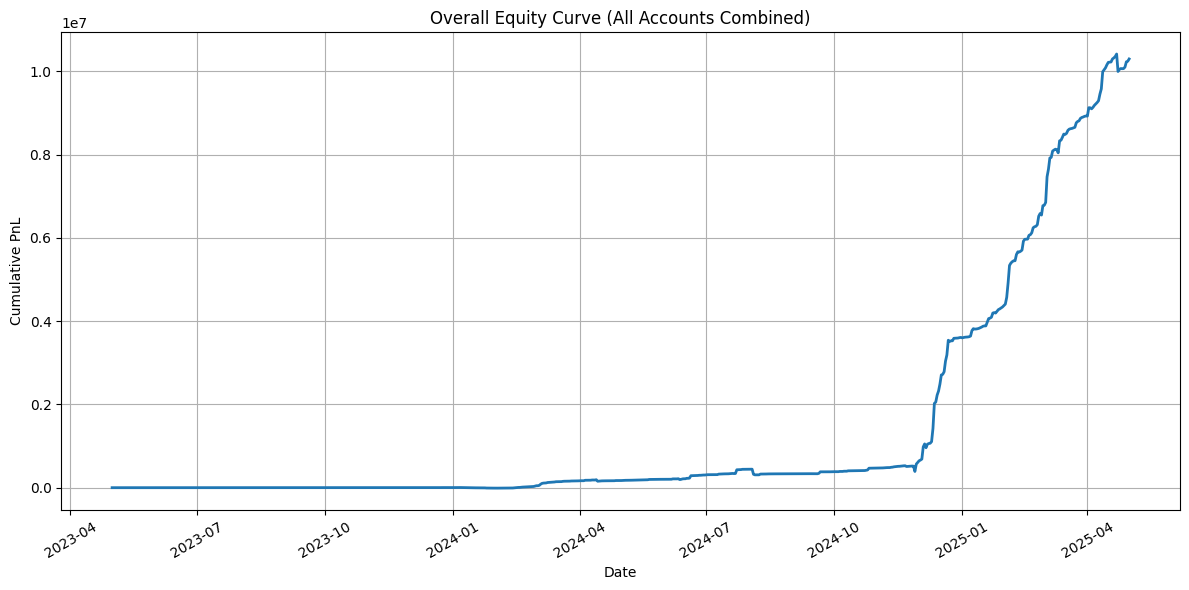

In [23]:




try:
    daily_pnl
except NameError:
    daily_pnl = trades.groupby(['Account', trades['timestamp_parsed'].dt.date], as_index=False)['Closed PnL'].sum()
    daily_pnl.columns = ['Account', 'date', 'Closed PnL']

# aggregate across accounts by date
overall_daily = daily_pnl.groupby('date', as_index=False)['Closed PnL'].sum().sort_values('date')
overall_daily['equity'] = overall_daily['Closed PnL'].cumsum()

plt.figure(figsize=(12,6))
plt.plot(overall_daily['date'], overall_daily['equity'], linewidth=2)
plt.title('Overall Equity Curve (All Accounts Combined)')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()

OUT = "overall_equity_curve.png"
plt.savefig(OUT)
print("Saved:", OUT)
plt.show()


Saved: overall_drawdown_curve.png


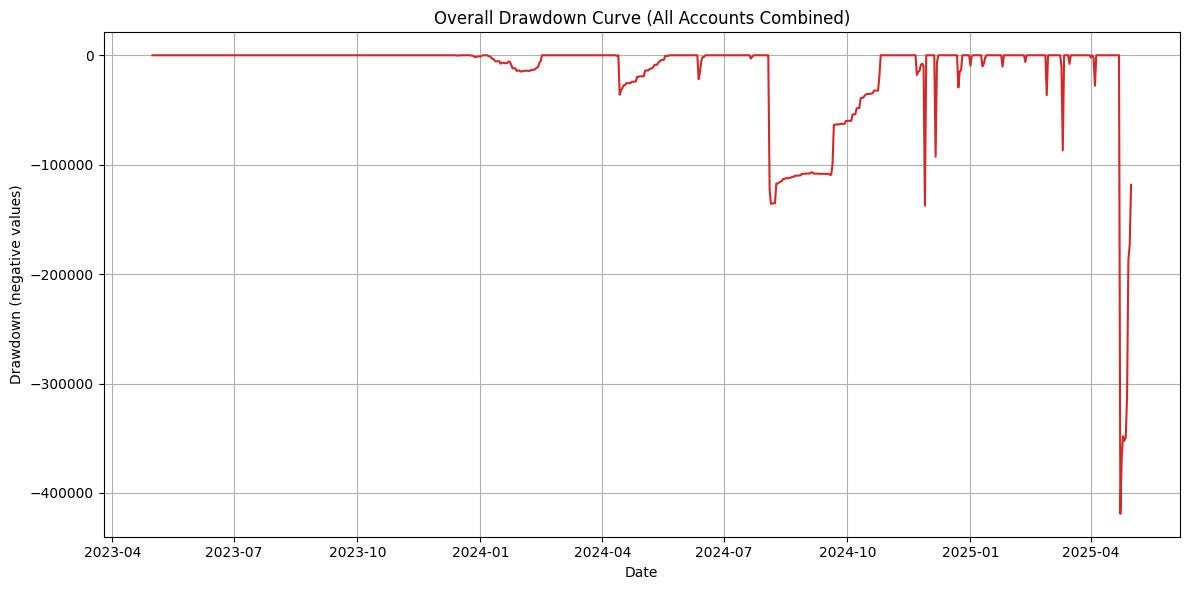

In [24]:


try:
    overall_daily
except NameError:
    overall_daily = daily_pnl.groupby('date', as_index=False)['Closed PnL'].sum().sort_values('date')
    overall_daily['equity'] = overall_daily['Closed PnL'].cumsum()

# create a continuous daily index (fill missing days)
idx = pd.date_range(start=pd.to_datetime(overall_daily['date']).min(),
                    end=pd.to_datetime(overall_daily['date']).max(), freq='D')
equity_ts = overall_daily.set_index(pd.to_datetime(overall_daily['date']))['equity'].reindex(idx, method='ffill').fillna(0.0)
cummax = equity_ts.cummax()
drawdown = equity_ts - cummax  # negative or zero

plt.figure(figsize=(12,6))
plt.plot(drawdown.index, drawdown.values, color='tab:red', linewidth=1.5)
plt.title('Overall Drawdown Curve (All Accounts Combined)')
plt.xlabel('Date')
plt.ylabel('Drawdown (negative values)')
plt.grid(True)
plt.tight_layout()

OUT = "overall_drawdown_curve.png"
plt.savefig(OUT)
print("Saved:", OUT)
plt.show()


Top accounts: ['0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23', '0x083384f897ee0f19899168e3b1bec365f52a9012', '0xbaaaf6571ab7d571043ff1e313a9609a10637864']
Saved: top3_equity_curves.png


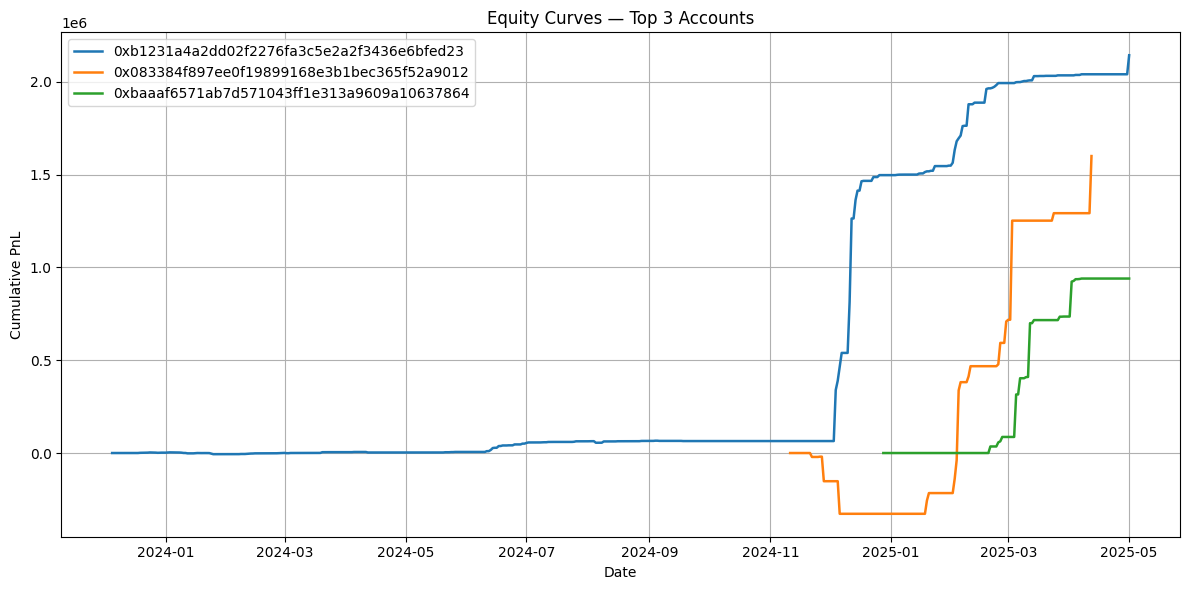

In [25]:

acct_totals = daily_pnl.groupby('Account', as_index=False)['Closed PnL'].sum().rename(columns={'Closed PnL':'total_pnl'}).sort_values('total_pnl', ascending=False)
top_accounts = acct_totals['Account'].head(3).tolist()
print("Top accounts:", top_accounts)

plt.figure(figsize=(12,6))
for acct in top_accounts:
    df = daily_pnl[daily_pnl['Account'] == acct].sort_values('date')
    # make continuous daily index
    idx = pd.date_range(start=pd.to_datetime(df['date']).min(), end=pd.to_datetime(df['date']).max(), freq='D')
    s = df.set_index(pd.to_datetime(df['date']))['Closed PnL'].reindex(idx, fill_value=0.0).cumsum()
    plt.plot(s.index, s.values, label=acct, linewidth=1.8)

plt.title('Equity Curves — Top 3 Accounts')
plt.xlabel('Date'); plt.ylabel('Cumulative PnL')
plt.legend(); plt.grid(True); plt.tight_layout()
OUT = "top3_equity_curves.png"
plt.savefig(OUT)
print("Saved:", OUT)
plt.show()


Saved: monthly_pnl_bar.png


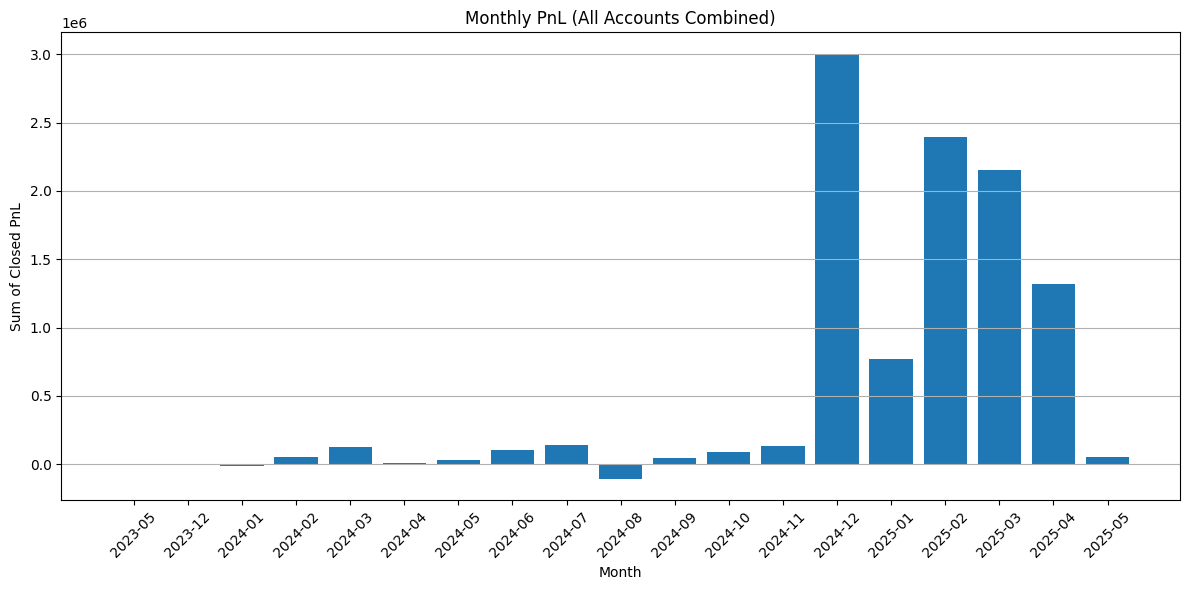

In [26]:

if 'timestamp_parsed' not in trades.columns:
    trades['timestamp_parsed'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", errors='coerce')

trades['month'] = trades['timestamp_parsed'].dt.to_period('M').dt.to_timestamp()
monthly = trades.groupby('month', as_index=False)['Closed PnL'].sum().sort_values('month')

plt.figure(figsize=(12,6))
plt.bar(monthly['month'].dt.strftime('%Y-%m'), monthly['Closed PnL'])
plt.title('Monthly PnL (All Accounts Combined)')
plt.xlabel('Month'); plt.ylabel('Sum of Closed PnL')
plt.xticks(rotation=45); plt.grid(axis='y'); plt.tight_layout()

OUT = "monthly_pnl_bar.png"
plt.savefig(OUT)
print("Saved:", OUT)
plt.show()


Saved: winloss_0xb1231a4a2dd02f2276.png


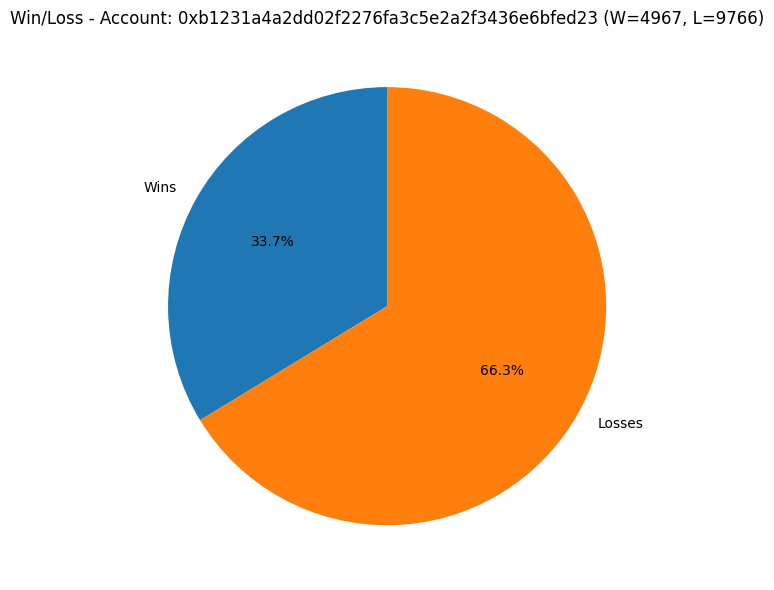

Saved: winloss_0x083384f897ee0f1989.png


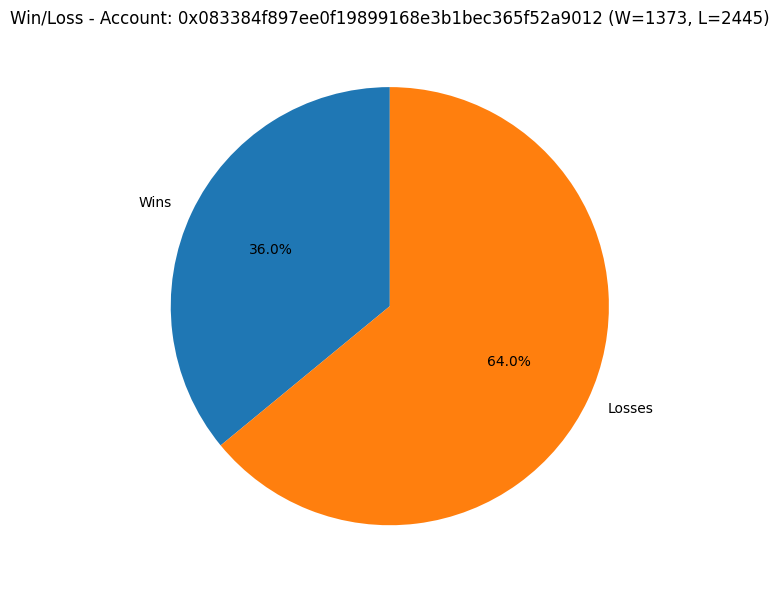

Saved: winloss_0xbaaaf6571ab7d57104.png


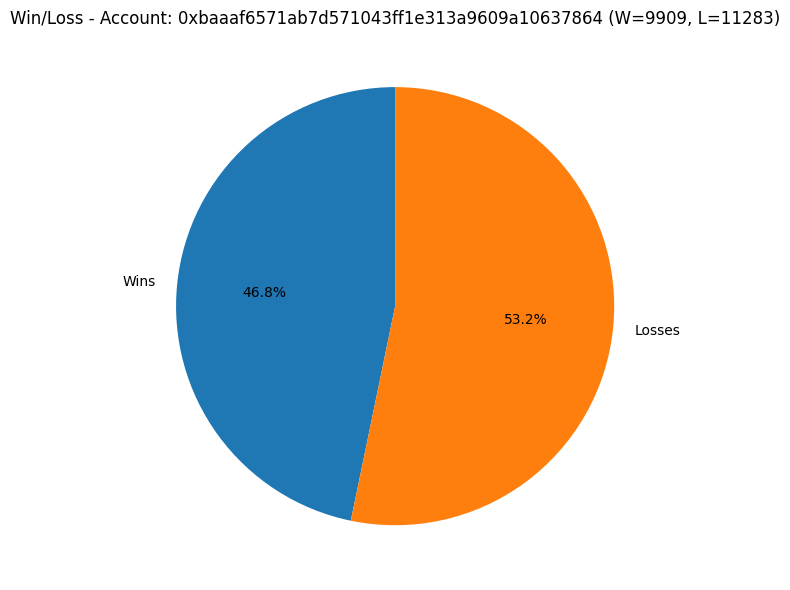

In [27]:
try:
    top_accounts
except NameError:
    acct_totals = daily_pnl.groupby('Account', as_index=False)['Closed PnL'].sum().sort_values('Closed PnL', ascending=False).rename(columns={'Closed PnL':'total_pnl'})
    top_accounts = acct_totals['Account'].head(3).tolist()

for acct in top_accounts:
    df = trades[trades['Account'] == acct]
    wins = int((df['Closed PnL'] > 0).sum())
    losses = int((df['Closed PnL'] <= 0).sum())
    plt.figure(figsize=(6,6))
    plt.pie([wins, losses], labels=['Wins', 'Losses'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Win/Loss - Account: {acct} (W={wins}, L={losses})')
    plt.tight_layout()
    fname = f"winloss_{acct[:20].replace('/','_')}.png"
    plt.savefig(fname)
    print("Saved:", fname)
    plt.show()





